#### Value at Risk and Conditional Value at Risk Engine Overview

In this project, I explore the different methods of calculating VaR and CVaR.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy.stats import gaussian_kde

In the cell below I am pulling the data from the csv I created, and doing calculations for log returns, covariance matrix, portfolio weights, variance, and standard deviation.

In [118]:
# Load prices from adj close prices csv and computing log returns
prices = pd.read_csv("adj_close_prices.csv", parse_dates=["Date"], index_col="Date").sort_index()

log_returns = np.log(prices / prices.shift(1)).dropna()

# Compute covariance matrix
cov_matrix = log_returns.cov()

# Generating portfolio weights
weights = np.array([1/6]*6)

# Calculating variance
variance = weights.T @ cov_matrix @weights

# Calculating standard deviation
std_dev = np.sqrt(variance)

hist_returns = (log_returns * weights).sum(axis=1)

### Historical Value at Risk
The basis of Historical Value at Risk is based off of a confidence level eg. 95%, a holding period, and then identifying a corresponding loss amount. This represents the probability of not exceeding the potential loss amount we identified, where the holding period is the time during which the risk is being estimated.

An advantage of the historical method is simplicity of calculation since it doesn't require any assumptions and uses real historical events.

Limitations would be that we are assuming that history is going to repeat itself, which is not a particularly strong assumption. For example, in extreme events like the COVID crisis and the 2008 crisis, it cannot be reliable.

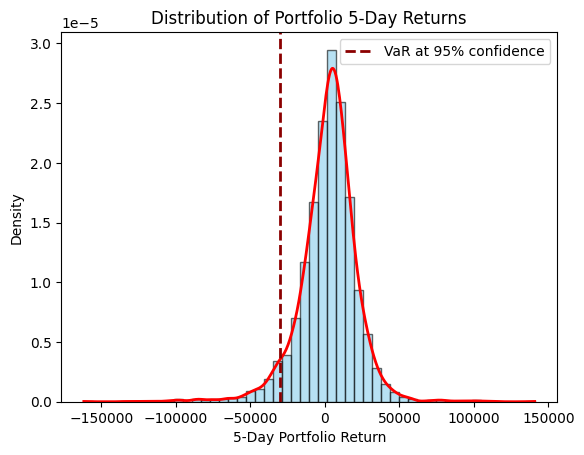

29973.797748944755


In [93]:
# Historical VaR
def Historical_VaR(weights, log_returns, portfolio_value, confidence, lookback_days=5, plot=False):
    
    range_returns = log_returns.rolling(window=lookback_days).sum()
    range_returns = range_returns.dropna()
    
    portfolio_returns = range_returns.dot(weights)
    
    percentile = (1 - confidence) * 100 
    
    VaR = -np.percentile(portfolio_returns, percentile) * portfolio_value

    if plot:

        # Convert to portfolio value terms
        range_returns_total = portfolio_returns * portfolio_value

        # Histogram (normalized to probability density)
        plt.hist(range_returns_total, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

        # KDE curve
        kde = gaussian_kde(range_returns_total)
        x_vals = np.linspace(range_returns_total.min(), range_returns_total.max(), 500)
        y_vals = kde(x_vals)
        plt.plot(x_vals, y_vals, color='red', linewidth=2)

        # VaR line
        plt.axvline(-VaR, color='darkred', linestyle='dashed', linewidth=2, 
                    label=f'VaR at {confidence:.0%} confidence')
        
        plt.xlabel(f"{lookback_days}-Day Portfolio Return")
        plt.ylabel("Density")
        plt.title(f"Distribution of Portfolio {lookback_days}-Day Returns")
        plt.legend()
        plt.show()

    return VaR
print(Historical_VaR(weights, log_returns, 1000000, .95, plot=True))


### Parametric Value at Risk

Parametric Value at Risk requires an expected return and the standard deviation, and it assumes returns are normally distributed. It is similar to the historical data but it uses a familiar curve instead of the actual data.

An advantage of this method is that we can see where the worst 5% or 1% lie on the curve.

A disadvantage of the parametric method is that since we assume a normal distribution it ignores possible fat tails of risk.


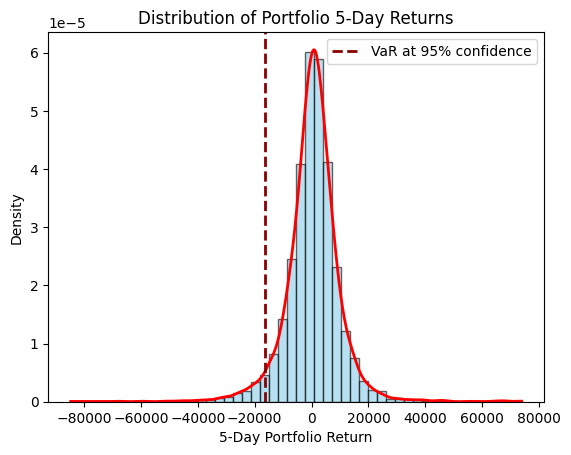

16220.664785665607


In [116]:
# Parametric (Normal) VaR
def Parametric_VaR(std_dev, portfolio_returns, portfolio_value, confidence, lookback_days, plot=False):
    hist_xday_returns = portfolio_returns.rolling(window=lookback_days).sum()
    z_score = norm.ppf(1-confidence)
    VaR = portfolio_value * std_dev * -z_score

    if plot:
        # Convert to portfolio value terms
        range_returns_total = portfolio_returns * portfolio_value

        # Histogram (normalized to probability density)
        plt.hist(range_returns_total, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

        # KDE curve
        kde = gaussian_kde(range_returns_total)
        x_vals = np.linspace(range_returns_total.min(), range_returns_total.max(), 500)
        y_vals = kde(x_vals)
        plt.plot(x_vals, y_vals, color='red', linewidth=2)

        # VaR line
        plt.axvline(-VaR, color='darkred', linestyle='dashed', linewidth=2, 
                    label=f'VaR at {confidence:.0%} confidence')
        
        plt.xlabel(f"{lookback_days}-Day Portfolio Return")
        plt.ylabel("Density")
        plt.title(f"Distribution of Portfolio {lookback_days}-Day Returns")
        plt.legend()
        plt.show()
    return VaR
print(Parametric_VaR(std_dev, hist_returns, 1000000, .95, 5, True))


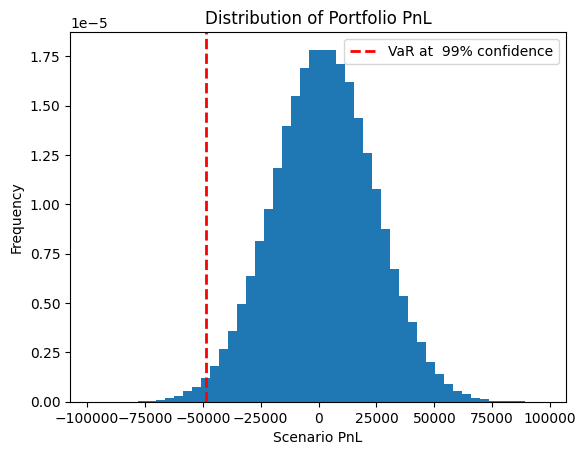

48737.3438443384


In [134]:
def portfolio_pnl(portfolio_value, days, expected_returns, z_score, std_dev):
    return portfolio_value * expected_returns * days + portfolio_value * std_dev * z_score * np.sqrt(days)

def Monte_Carlo_VaR(log_returns, weights, std_dev, portfolio_value, days, simulations, confidence, plot):
    
    expected_returns = np.sum(log_returns.mean() * weights)

    scenario_returns = []

    for i in range(simulations):
        z_score = np.random.normal(0,1)
        scenario_returns.append(portfolio_pnl(portfolio_value, days, expected_returns, z_score, std_dev))

    VaR = -np.percentile(scenario_returns, 100 * (1-confidence))
    if plot:
        plt.hist(scenario_returns, bins=50, density=True)
        plt.xlabel('Scenario PnL')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Portfolio PnL')
        plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=(f'VaR at {confidence: .0%} confidence'))
        plt.legend()
        plt.show()
    return VaR



print(Monte_Carlo_VaR(log_returns, weights, std_dev, 1000000, 5, 100000, .99, True))